# Notebook to create Fig.4.8 of Thesis: Contour comparison between NIPE and SNPE



In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions as sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 17

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
window_len = 30

if num_params == 6:
    
    prior_min_fix = [0.0, 11.3, 0.0, 43.8, 0.0, 89.491]
    prior_max_fix = [0.160, 35.9, 0.821, 79.0, 8.104, 162.110]

    prior_min = [0.0, 11.3, 0.0, 43.8, 0.0, 89.491]
    prior_max = [0.160, 35.9, 0.821, 79.0, 8.104, 162.110]
    #true_params = torch.tensor([[26.61, 63.53,  137.12]])
    true_params = torch.tensor([[0.0274, 19.01, 0.1369, 61.89, 0.1435, 120.86]])

    

if num_params == 25:
    prior_min = [0, 0, 0, 0, 0, 0, 0, 0, 13.3,    # prox1 weights
                 0, 0, 0, 0, 0, 0, 51.980,            # distal weights
                 0, 0, 0, 0, 0, 0, 0, 0, 112.13]       # prox2 weights


    # ampa, nmda [0.927, 0.160, 2.093, 0.0519,        1.0, 1.0, 1.0, 1.0, 35.9,
    #           0.0394, 0.000042, 0.039372,           0.854, 0.117,  0.480, 75.08,
    #            0.000018, 8.633, 0.05375, 4.104,     1.0, 1.0, 1.0, 1.0, 162.110]

    prior_max = [0.927, 1.0, 0.160, 1.0,  2.093, 1.0, 0.0519, 1.0, 35.9,
                 0.0394, 0.117, 0.000042, 0.025902, 0.854, 0.480, 75.08,
                 0.000018, 1.0, 8.633, 1.0, 0.05375, 1.0, 4.104,  1.0, 162.110]

    true_params = torch.tensor([[0.277, 0.3739, 0.0399, 0.0, 0.6244, 0.3739, 0.034, 0.0, 18.977,
                                 0.011467, 0.06337, 0.000012, 0.013407, 0.466095, 0.0767, 63.08,
                                 0.000005, 0.116706, 4.6729, 0.016733, 0.011468, 0.061556, 2.33, 0.0679, 120.86]])
    
if num_params == 17:
    
    prior_min = [0, 0, 0, 0, 0, 13.3,  0, 0, 0, 0, 0, 51.980, 0, 0, 0, 0, 112.13]
    prior_max = [0.927, 0.160, 2.093, 1.0, 1.0, 35.9, 0.000042, 0.039372, 0.025902,  0.480, 0.117, 75.08, 8.633, 4.104, 1.0, 1.0, 162.110]

    true_params = torch.tensor([[0.277, 0.0399, 0.6244, 0.3739, 0.0, 18.977, 0.000012, 0.0115, 0.0134,  0.0767, 0.06337, 63.08, 4.6729, 2.33, 0.016733, 0.0679, 120.86]])


prior = utils.torchutils.BoxUniform(low=prior_min, high=prior_max)

#number_simulations = 10
density_estimator = 'nsf'


In [5]:

#assert (prior.event_shape==torch.Size([25]))
from utils import inference

In [8]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os


file = 'multi_round_17params'


print(os.getcwd())

os.chdir('results')


print(os.getcwd())
  

#thetas = torch.load('{}/thetas.pt'.format(file))

posterior = torch.load('{}/posterior.pt'.format(file))



/home/ubuntu
/home/ubuntu/results


In [10]:
samples = posterior.sample((1000,), not_within_prior=False)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/nflows/transforms/lu.py:81: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755861072/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  outputs.t(), lower, upper=False, unitriangular=True
                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 999 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normaliz

acceptance rate:  0.0
acceptance rate:  9.09090909090909e-05
acceptance rate:  9.523809523809524e-05
acceptance rate:  6.451612903225807e-05
acceptance rate:  7.317073170731707e-05
acceptance rate:  7.843137254901961e-05
acceptance rate:  6.557377049180328e-05
acceptance rate:  8.450704225352113e-05
acceptance rate:  7.407407407407407e-05
acceptance rate:  7.692307692307693e-05
acceptance rate:  8.91089108910891e-05
acceptance rate:  8.108108108108108e-05
acceptance rate:  7.43801652892562e-05
acceptance rate:  7.633587786259542e-05
acceptance rate:  7.092198581560284e-05
acceptance rate:  7.947019867549669e-05
acceptance rate:  8.074534161490683e-05
acceptance rate:  8.187134502923976e-05
acceptance rate:  7.734806629834254e-05
acceptance rate:  8.37696335078534e-05
acceptance rate:  8.45771144278607e-05
acceptance rate:  8.530805687203791e-05
acceptance rate:  8.144796380090498e-05
acceptance rate:  8.225108225108226e-05
acceptance rate:  7.883817427385893e-05
acceptance rate:  8.366

In [11]:
parameter_names = ["prox1_ampa_l2_bas","prox1_ampa_l2_pyr","prox1_ampa_l5_bas","prox1_nmda_l5_bas", "prox1_nmda_l5_pyr",
 "t_prox1",
 "dist_ampa_l2_pyr","dist_ampa_l2_bas","dist_nmda_l2_pyr",
 "dist_nmda_l5_pyr","dist_nmda_l2_bas",
 "t_dist", 
 "prox2_ampa_l2_pyr","prox2_ampa_l5_pyr","prox2_nmda_l2_pyr","prox2_nmda_l5_pyr",
 "t_prox2"]

if num_params ==6:
    parameter_names = ["prox_1_ampa_l2_pyr",
     "t_evprox_1",
     "dist_nmda_l2_pyr",
     "t_evdist_1", 
     "prox_2_ampa_l5_pyr",
     "t_evprox_2"]

In [17]:

file = '10000sims_17params_11_04_nsf_fake_ratio'


posterior = torch.load('{}/posterior.pt'.format(file))

obs_real = torch.load('{}/obs_real.pt'.format(file))

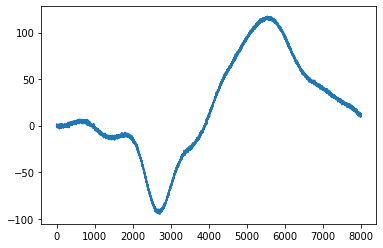

In [18]:
plt.plot(obs_real)

In [19]:
samples2 = posterior.sample((1000,))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [20]:
##better limits:

list_min = torch.min(torch.cat((samples2, samples), dim=0), 0)[0]
list_max = torch.max(torch.cat((samples2, samples), dim=0), 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.2

print(diff)

list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([-8.3189e-03,  1.1983e-03,  6.2900e-03,  3.3193e-03, -3.6229e-03,
         1.7333e+01, -1.2746e-05, -1.1204e-03,  8.2266e-04,  1.4073e-02,
        -2.5962e-02,  6.0434e+01, -2.5963e+00,  2.2028e-01, -1.7603e-03,
        -1.2520e-01,  1.1325e+02])
tensor([4.7037e-01, 1.5755e-01, 2.6095e+00, 9.1638e-01, 3.6853e-03, 2.7606e+01,
        4.2762e-05, 4.0860e-02, 3.2260e-02, 1.8348e-01, 1.1698e-01, 6.4884e+01,
        9.0029e+00, 4.1010e+00, 1.0307e+00, 2.1468e-01, 1.2531e+02])
tensor([9.5737e-02, 3.1270e-02, 5.2065e-01, 1.8261e-01, 1.4616e-03, 2.0546e+00,
        1.1102e-05, 8.3960e-03, 6.2875e-03, 3.3882e-02, 2.8589e-02, 8.9003e-01,
        2.3198e+00, 7.7614e-01, 2.0650e-01, 6.7976e-02, 2.4136e+00])


In [21]:
limits[4][0] = -0.01
limits[4][1] = 0.05

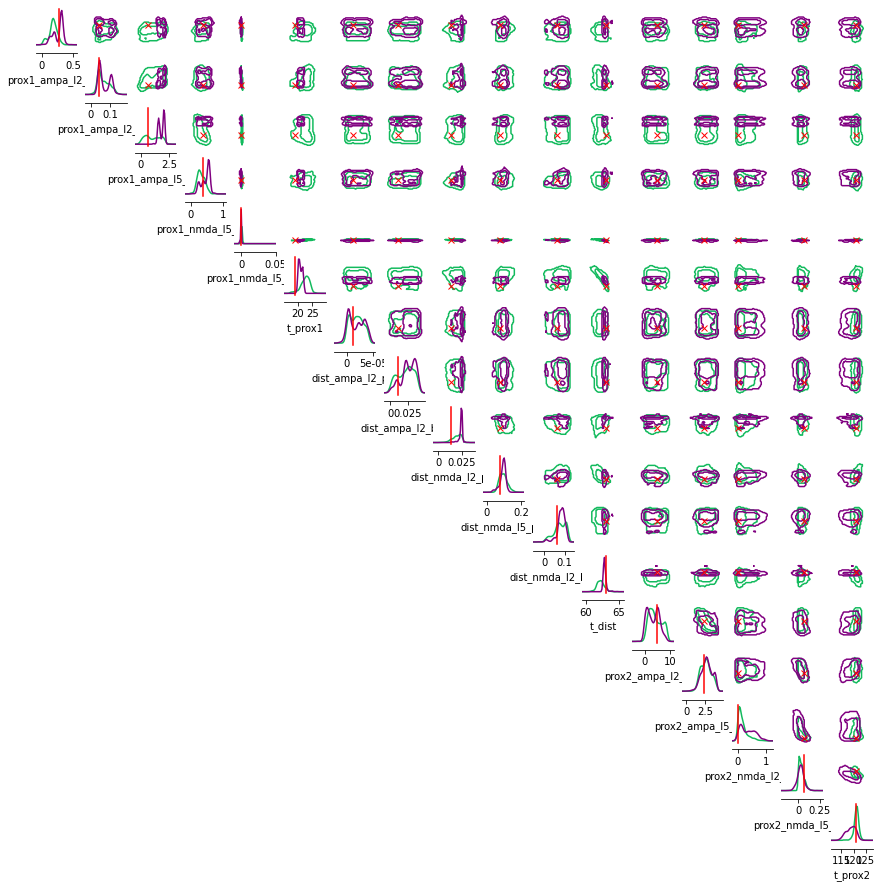

In [22]:
_ = analysis.pairplot(
    samples = [samples, samples2],
    points = true_params,
    limits = limits,
    #subset: List[int] = None,
    upper = "contour",
    diag = "kde",
    figsize = (15, 15),
    labels= parameter_names,

    #ticks: Union[List, torch.Tensor] = [],
    points_colors = 'red',
    kde_offdiag = {
            "alpha": [0.8, 0.2],
            #"edgecolor": "none",
            #"rasterized": False,
            #'s': mpl.rcParams['lines.markersize'] ** 0.5,
            "bw_method": "scott",
            "bins": 50,
            #'cmap': 'viridis'
        },
    hist_offdiag_alpha = 0.02,
    points_offdiag={"markersize": 6, 'marker': 'x'},
    #samples_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"],
    #fig=None,
    #axes=None,
    #**kwargs,
    scatter_offdiag = {
            "alpha": 0.2,
            "edgecolor": "none",
            "rasterized": True,
            's': mpl.rcParams['lines.markersize'] ** 0.5
        },
    contour_offdiag={"levels":  [0.68, 0.95]},
    samples_colors =  ['#12ba5d', '#800080'],
    legend = 'True'
)


In [35]:
plt.savefig('thesis_fig4_10comparison_snpe_nipe')

<Figure size 432x288 with 0 Axes>